# PCA Figure

A recapitulation of Jess' primer figure but written in python by Rob

In [1]:
import os
import sys
from random import randint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load the data table
df = pd.read_csv("../MGI/Taxonomy/MGI_reads_genus.normalised.tsv.gz", sep='\t', compression='gzip')
df = df[df['taxonomy'].str.contains('k__Bacteria')]
df = df[~df['taxonomy'].str.endswith('s__')]
df = df[~df['taxonomy'].str.endswith('g__')]
df = df[~df['taxonomy'].str.contains('g__;')]
df = df.set_index('taxonomy')
df.index = df.index.str.split(';').str[-1]

df = df.T

df.head()

taxonomy,g__Candidatus Aegiribacteria,g__Candidatus Kapaibacterium,g__Candidatus Stahlbacteria,g__Vermiphilus,g__Candidatus Babela,g__Candidatus Chromulinivorax,g__Candidatus Ozemobacter,g__Candidatus Desulfacyla,g__Dissulfurimicrobium,g__Dissulfurirhabdus,...,g__Oceaniferula,g__Persicirhabdus,g__Phragmitibacter,g__Prosthecobacter,g__Roseibacillus,g__Roseimicrobium,g__Sulfuriroseicoccus,g__Verrucomicrobium,g__Candidatus Eremiobacter,g__Candidatus Methylomirabilis
768745_20190228_BAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
698917_20180329_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
788707_20171213_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
698917_20171207_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
896213_20180427_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.980057,0.0,0.0


In [3]:
# Load metadata table
# This is generic so we can copy/paste. Yes, it should be a function, but its not.

# sequence_type = 'minion_ID'
sequence_type = 'MGI_ID'

metadata = pd.read_csv("../Metadata/Metadata20241026.txt", encoding='windows-1252', sep="\t", index_col=0)
metadata = metadata[~metadata[sequence_type].isna()]
todrop = []
for s in metadata[sequence_type]:
    if s not in df.index:
        print(f"ERROR: {s} not found in data frame, dropped from metadata", file=sys.stderr)
        todrop.append(s)

metadata.drop(todrop, inplace=True)

todrop = []
for s in df.index:
    if not metadata[sequence_type].str.contains(s).any():
        print(f"ERROR: {s} not found in metadata, dropped from dataframe", file=sys.stderr)
        todrop.append(s)
df.drop(todrop, inplace=True)
        
if metadata.shape[0] != df.shape[0]:
    print(f"ERROR: we have {metadata.shape[0]} rows in metadata and {df.shape[0]} data rows", file=sys.stderr)
metadata.head()

ERROR: 1723809_20180227_S not found in metadata, dropped from dataframe
ERROR: 1316979_20171215_S not found in metadata, dropped from dataframe
ERROR: 1255498_20171212_S not found in metadata, dropped from dataframe
ERROR: 652927_20180226_S not found in metadata, dropped from dataframe
ERROR: 1112926_20171212_S not found in metadata, dropped from dataframe


,minion_ID,MGI_ID,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,Paediatric vs Adult,...,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171
NAME,,,,,,,,,,,,,,,,,,,,,
623361_20180123_S,623361_20180123_S,623361_20180123_S,623361,1/23/2018,OP,RAH,Chest Clinic 9,18,4,Adult,...,33.60,GAGATTCC,GGCTCTGA,468,2.4,NaN,NaN,NaN,NaN,NaN
634207_20180510_S,NaN,634207_20180510_S,634207,5/10/2018,IP,WCH,Adol Rm9,17,3,Paediatric,...,7.82,CGGACGATTC,CCACCACCTA,651,2.9,NaN,NaN,NaN,NaN,NaN
634207_20180517_S,NaN,634207_20180517_S,634207,5/17/2018,IP,WCH,Adol Rm9,17,3,Paediatric,...,22.80,AGCGATAG,CCTATCCT,633,2.4,NaN,NaN,NaN,NaN,NaN
639354_20171206_S,639354_20171206_S,639354_20171206_S,639354,12/06/2017,IP,WCH,Adolescent 10,17,3,Paediatric,...,20.80,ATTACTCG,TAATCTTA,337,4.9,NaN,NaN,NaN,NaN,NaN
642660_20180601_S,642660_20180601_S,642660_20180601_S,642660,6/01/2018,IP,WCH,Adol Rm 11,17,3,Paediatric,...,21.80,GAATTCGT,GGCTCTGA,491,4.8,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='g__Pseudomonas', ylabel='Density'>

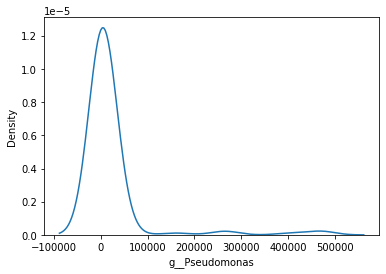

In [4]:
sns.kdeplot(data=df['g__Pseudomonas'])

In [5]:
genus = 'g__Pseudomonas'
list(df[df[genus] < 100][genus])
df[df[genus] > 0].shape

(122, 3581)

In [6]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 'g__Pseudomonas'
mn = np.mean(df[df[genus] > 0][genus])
md = np.median(df[df[genus] > 0][genus])
print(f"The mean for {genus} is {mn} and the median is {md}", file=sys.stderr)

nonzeromean = np.median(df[df[genus] > 0][genus])
bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
#bins = [-1, 200, 5000, 10000, float('inf')]
labels = ['small', 'medium', 'large']
sizelist = [50, 200, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['g__Pseudomonas'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['g__Pseudomonas'], bins=bins, labels=marker_shapes))

The mean for g__Pseudomonas is 21540.580387052112 and the median is 2777.5696455528214


In [7]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

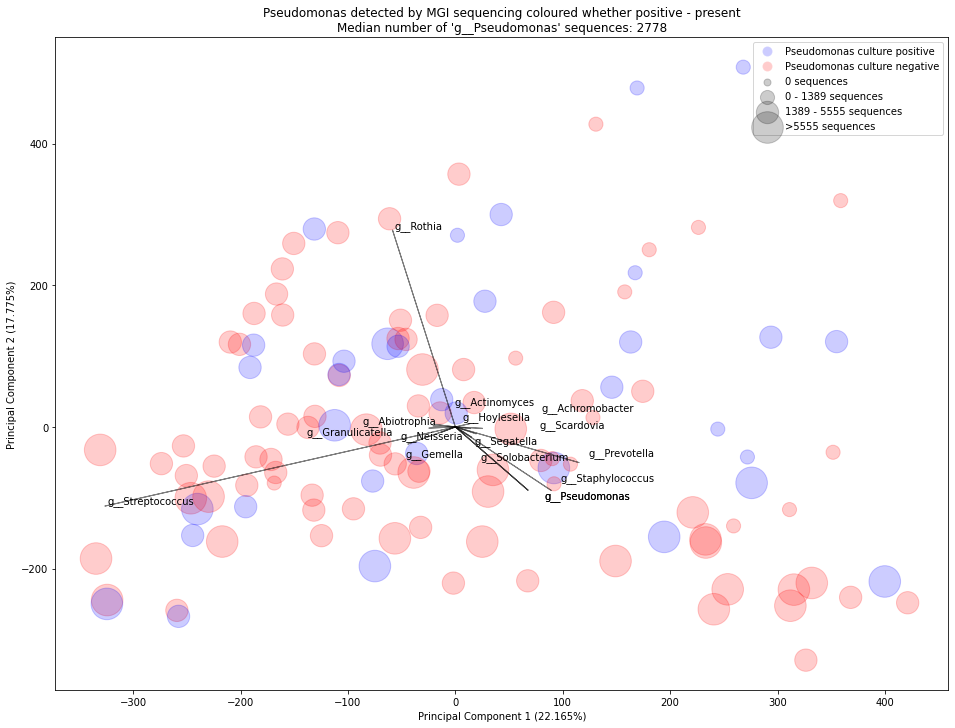

In [13]:
# Map colors based on the metadata column
colours = np.where(metadata['CS_Pseudomonas aeruginosa'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MGI sequencing coloured whether positive - present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('g__Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('img/MGI_genus_pseudomonas_present.png')
# Show the plot
plt.show()

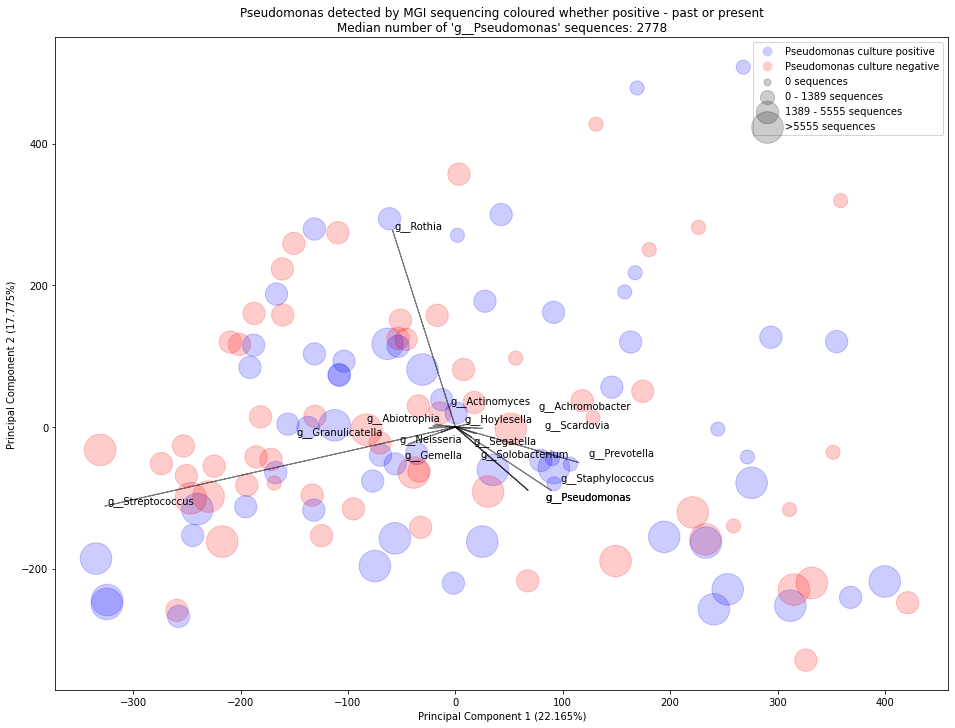

In [12]:
# Map colors based on the metadata column
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MGI sequencing coloured whether positive - past or present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('g__Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('img/MGI_genus_pseudomonas_past_present.png')
# Show the plot
plt.show()

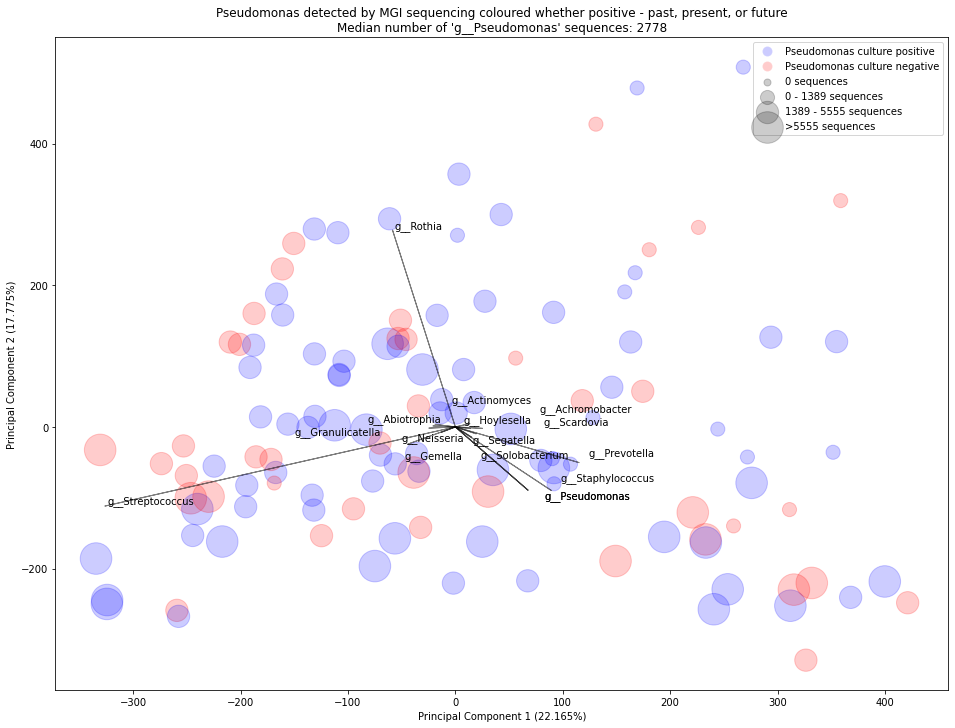

In [11]:
# Map colors based on the metadata column
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MGI sequencing coloured whether positive - past, present, or future' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('g__Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('img/MGI_genus_pseudomonas_past_present_future.png')
# Show the plot
plt.show()